In Aug 2024, Starbucks announced a CEO change without any other materially confounding information (e.g. it wasn't along an earnings report). Events like these are something companies and investors are regularly interested in quantifying impact -- but naturally don't want to design an experiment randomly giving users bad experiences

Examples of how this might transfer: Suppose there is an outage that affects a certain region or population of users (iOs but not Android, NYC but not San Francisco or LA, purchasers of product X but not Y, etc.). If you have a time series of performance by these groups, you may consider these models to estimate the impact.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.formula.api as smf

In [27]:
def run_diff_in_diff(df, event_date, treated):
    start_date = event_date - datetime.timedelta(days=180)
    df = df[(df['date'] >= start_date) & (df['date'] <= event_date) & (df['returns'].isnull()==0)].copy()
    df['treated'] = np.where(df['ticker']==treated, 1, 0)
    df['post'] = np.where(df['date']>=event_date, 1, 0)
    df['treated_post'] = df['treated'] * df['post']

    formula = "returns ~ treated + post + treated_post"
    model = smf.ols(formula=formula, data=df).fit()
    return model


def difference_in_trends(df, event_date, treated):
    start_date = event_date - datetime.timedelta(days=180)
    df = df[(df['date'] >= start_date) & (df['date'] <= event_date)].copy()
    df['treated'] = np.where(df['ticker']==treated, 1, 0)
    df['trend'] = (event_date - df['date']).dt.days
    df['treated_trend'] = df['treated']*df['trend']
    formula = "returns ~ treated + trend + treated_trend"
    model = smf.ols(formula=formula, data=df).fit()
    return model


def plot_histogram(df, model, param, mytitle):
    quantile_2_5 = df['betas'].quantile(0.025)
    quantile_97_5 = df['betas'].quantile(0.975)
    model_est = model.params[param]

    plt.hist(df['betas'], bins=10, alpha=0.7)
    plt.axvline(quantile_2_5, color='black', linestyle='--', linewidth=1, label='2.5th pctl')
    plt.axvline(quantile_97_5, color='black', linestyle='--', linewidth=1, label='97.5th pctl')
    plt.axvline(model_est, color='red', linestyle='--', linewidth=1, label='Event Impact')
    plt.legend(loc='upper left')
    plt.title(mytitle)
    plt.show()
    
    
def get_event_study_placebos(df_wide, pre_event_dates, cutoff_days, formula):
    pvalues = list()
    betas = list()
    
    for placebo_date in pre_event_dates:
        cutoff = pd.to_datetime(placebo_date) - datetime.timedelta(days=cutoff_days)
        placebo_df = df_wide[(df_wide['date'] >= cutoff) & (df_wide['date'] <= placebo_date)].copy()
        placebo_df['event'] = np.where(placebo_df['date']==placebo_date,1,0)
        placebo_model=smf.ols(formula=formula, data=placebo_df).fit()
        pvalues.append(placebo_model.pvalues['event'])
        betas.append(placebo_model.params['event'])

    placebo_estimates = pd.DataFrame({'betas':betas, 'pvalues':pvalues})
    rmse = np.sqrt((placebo_estimates['betas']**2).mean())

    return(placebo_estimates,rmse)


In [40]:
event_date = '2024-08-13'
prices = pd.read_csv('sbux_ceo_prices.csv')
prices = prices[prices['returns'].isnull()==0].copy()
print(prices['date'].agg(['min','max']))
prices.head()

min    2024-01-03
max    2024-08-30
Name: date, dtype: object


,date,open,high,low,close,adjclose,volume,ticker,returns
1,2024-01-03,93.959999,94.239998,93.059998,93.230003,89.737877,7161700,SBUX,-0.004697
2,2024-01-04,93.099998,94.580002,93.000000,93.550003,90.045891,7118600,SBUX,0.003432
3,2024-01-05,93.330002,93.580002,92.480003,92.989998,89.506859,7189900,SBUX,-0.005986
4,2024-01-08,93.019997,94.570000,92.949997,94.190002,90.661919,7536900,SBUX,0.012905
5,2024-01-09,93.610001,93.730003,92.860001,93.089996,89.603111,6348500,SBUX,-0.011679


In [29]:
# Mean/SD returns for each of the tickers
prices[prices['date']<event_date].groupby(['ticker'])['returns'].agg(['count','mean','std'])


,count,mean,std
ticker,,,
MCD,153,-0.000568,0.011725
QSR,153,-0.000522,0.014667
SBUX,153,-0.001079,0.019548
VOO,153,0.000826,0.007927
YUM,153,0.000379,0.010292


### Estimate event study model

In [30]:
df_wide = prices.pivot(index='date', columns='ticker', values='returns')
df_wide.reset_index(inplace=True)
df_wide.columns.name = None
df_wide['date'] = pd.to_datetime(df_wide['date'])
df_wide.head()
df_wide.drop(columns=['QSR'], inplace=True)

In [31]:
preperiod_days = 120
postperiod_days = 1

event_date = pd.to_datetime(event_date)
model_start_date = event_date - datetime.timedelta(days=preperiod_days)
model_end_date = event_date + datetime.timedelta(days=postperiod_days)

df = df_wide[(df_wide['date'] >= model_start_date) & (df_wide['date'] < model_end_date)].copy()
df['event'] = np.where(df['date']==event_date,1,0)


formula = 'SBUX~MCD+VOO+YUM+event'
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   SBUX   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     36.91
Date:                Mon, 16 Jun 2025   Prob (F-statistic):           2.23e-17
Time:                        23:10:02   Log-Likelihood:                 203.84
No. Observations:                  84   AIC:                            -397.7
Df Residuals:                      79   BIC:                            -385.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0007      0.002     -0.295      0.7

In [32]:
# Obtain the baseline market value using known value of total shares and price just prior to the event date
total_shares = 1132800000

prices['date'] = pd.to_datetime(prices['date'])
pre = prices[prices['date']<event_date].copy()
lastprice = pre.loc[(pre['date']==max(pre['date'])) & (pre['ticker']=='SBUX'),'close'].values[0]
lastmarketvalue = lastprice * total_shares

print("Last Market Value: ${:,}".format(round(lastmarketvalue)))
print("Estimated Gain: ${:,}".format(round(lastmarketvalue*model.params['event'])))

Last Market Value: $87,259,582,617
Estimated Gain: $19,976,389,929


Mean Placebo Effect: 0.001
RMSE: 0.026


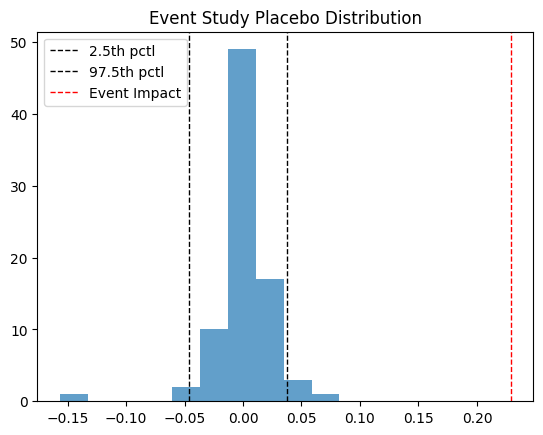

In [33]:
placebo_start = event_date - datetime.timedelta(days=120)
pre_event_dates = df_wide[(df_wide['date'] >= placebo_start) & (df_wide['date'] < event_date)]['date'].unique()
mytitle = "Event Study Placebo Distribution"
placebo_estimates, rmse = get_event_study_placebos(df_wide, pre_event_dates, preperiod_days, formula)

print(f"Mean Placebo Effect: {placebo_estimates.betas.mean():.3f}")
print(f"RMSE: {rmse:.3f}")
plot_histogram(placebo_estimates, model,"event", mytitle)

In [46]:
preperiod_days = 120
postperiod_days = 4

event_date = pd.to_datetime(event_date)
model_start_date = event_date - datetime.timedelta(days=preperiod_days)
model_end_date = event_date + datetime.timedelta(days=postperiod_days)

df = df_wide[(df_wide['date'] >= model_start_date) & (df_wide['date'] < model_end_date)].copy()
df.sort_values(by='date', ascending=True, inplace=True)
df['t'] = range(1, len(df) + 1)

event_index = df.loc[df['date'] == event_date, 't'].values[0]

df['pre1'] = df['t'].apply(lambda x: 1 if x == event_index-1 else 0)
df['pre2'] = df['t'].apply(lambda x: 1 if x == event_index-2 else 0)
df['pre3'] = df['t'].apply(lambda x: 1 if x == event_index-3 else 0)
df['post0'] = df['t'].apply(lambda x: 1 if x == event_index else 0)
df['post1'] = df['t'].apply(lambda x: 1 if x == event_index+1 else 0)
df['post2'] = df['t'].apply(lambda x: 1 if x == event_index+2 else 0)
df['post3'] = df['t'].apply(lambda x: 1 if x == event_index+3 else 0)

formula = 'SBUX~MCD+VOO+YUM+pre3+pre2+pre1+post0+post1+post2+post3'
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   SBUX   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     15.18
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           1.78e-14
Time:                        22:32:10   Log-Likelihood:                 214.31
No. Observations:                  87   AIC:                            -406.6
Df Residuals:                      76   BIC:                            -379.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0011      0.002     -0.439      0.6

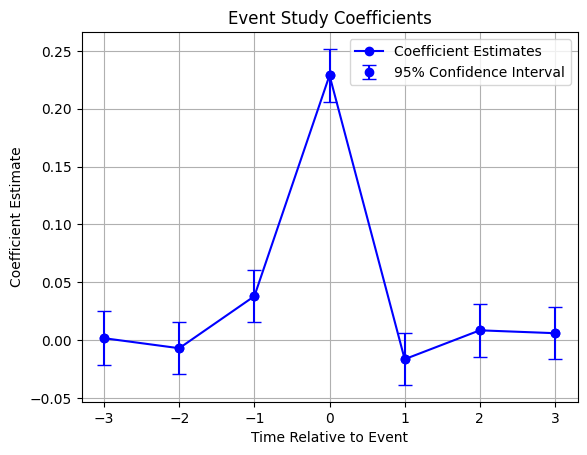

In [ ]:
# Extract coefficients for pre3, pre2, pre1, post0, post1, post2, and post3
coefficients = ['pre3', 'pre2', 'pre1', 'post0', 'post1', 'post2', 'post3']
x_values = range(-3, 4)  # x values from -3 to +3
y_values = [model.params[coef] for coef in coefficients]

# Add error bars using standard errors from model.bse
y_errors = [model.bse[coef] for coef in coefficients]

# Plot the coefficient estimates as a connected line graph
plt.plot(x_values, y_values, marker='o', color='b', label='Coefficient Estimates')

# Add error bars to the plot
plt.errorbar(x_values, y_values, yerr=y_errors, fmt='o', color='b', capsize=5, label='95% Confidence Interval')
plt.title('Event Study Coefficients')
plt.xlabel('Time Relative to Event')
plt.ylabel('Coefficient Estimate')
plt.xticks(x_values)
plt.legend()
plt.grid(True)
plt.show()